# Setup

This notebook contains visualizations of the predictions in the form of graphs

In [1]:

import os
import shutil
import re
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')


Define functions and dictionaries for graph formatting

In [2]:
def savefigtight(figname):
  if not os.path.exists("images"):
    os.makedirs("images")
  plt.savefig(os.path.join("images", figname), bbox_inches="tight")

cmap_tab = lambda position : mpl.colormaps['tab20c'](position)
cmap_tab2 = lambda position : mpl.colormaps['tab10'](position)
cmap_tvt = lambda split: mpl.colormaps['tab20c'](0.2 if split=="tr" else 0.35 if split=="te" else 0.25)
cmap_sex = lambda sex_f: mpl.colormaps['tab20'](0.0 if sex_f==1 else 0.05)


In [3]:
abbr = {"EOD": "Equal odds difference (EOD)", "AOD": "Average odds difference (AOD)", "DI": "Disparate impact (DI)", "SPD": "Statistical parity index (SPD)", "ACC": "Accuracy (ACC)", "REC":"Recall (REC)", "MCC":"Matthews correlation coefficient (MCC)", "SPE":"Specificity (SPE)"}
abbr_n = {"EOD": "Equal odds\ndifference (EOD)", "AOD": "Average odds\ndifference (AOD)", "DI": "Disparate impact\n(DI)", "SPD": "Statistical parity\nindex (SPD)", "ACC": "Accuracy\n(ACC)", "REC":"Recall (REC)", "MCC":"Matthews correlation\ncoefficient (MCC)", "SPE":"Specificity\n(SPE)"}

## Load Data

In [4]:

def addTFNP(df):
  """
  Adds confusion matrix values (true positive, false positive, true negative, and false negative) to the DataFrame provided in the column "CM"

  Parameters:
    df (pandas.DataFrame) : DataFrame containing a true/false ("TF") and "Prediction" column
  Returns:
    out (pandas.DataFrame) : The original DataFrame, with confusion matrix values added
  """
  tpfn = []
  tpfn_full = []
  for index, row in df.iterrows():
      cm_val = ""
      cm_long = ""
      if row["TF"] ==1:
         cm_val = "T"
         cm_long = "true "
      else:
        cm_val = "F"
        cm_long = "false "

      cm_val +=  "P" if row["Prediction"] == 1 else "N"
      cm_long +=  "positive" if row["Prediction"] == 1 else "negative"
      tpfn+=[cm_val]
      tpfn_full+=[cm_long]
  df_n = df.copy(deep=True)
  df_n["CM"] = tpfn
  df_n["CM_full"] = tpfn_full
  return df_n


def getAnalysisDF():
  """
  Creates a pandas DataFrame summarizing all information in the dataset related to the model's predictions

  Returns:
    out (pandas.DataFrame): DataFrame of prediction data
  """

  df_raw = pd.read_excel(os.getenv("RAWTAB"))
  df_raw = df_raw[df_raw["MRI ID"].isin(pd.read_excel(os.getenv("PREDICTTAB"))["MRI ID"].unique())]


  df_norm= pd.read_excel(os.getenv("NORMTAB"))
  df_norm= df_norm[df_norm["MRI ID"].isin(pd.read_excel(os.getenv("PREDICTTAB"))["MRI ID"].unique())]

  df_combo = pd.merge(left=df_raw, right=df_norm, on="MRI ID", suffixes=["_raw", "_norm"], how="outer")
  df_pred = pd.merge(df_combo, pd.read_excel(os.getenv("PREDICTTAB")).drop(columns=["Group"]), how="outer")


  uid = []

  for f in df_pred["File"]:
    m = re.match("(OAS2_[0-9]{4}_MR[0-9]{1}_F[0-9]{1})_[0-9]{2}.jpg", f)
    uid += [m.groups()[0]]

  df_pred["Unique ID"] = uid

  return addTFNP(df_pred)

def getSplitDF():
    """
    Gets the DataFrame containing training/testing/validation split sets

    Returns:
      out (pandas.DataFrame): DataFrame of training/testing/validation split sets
    """
    df_split = pd.read_excel(os.getenv("SPLITTAB"))
    df_raw = pd.read_excel(os.getenv("RAWTAB"))
    df_raw = df_raw[df_raw["MRI ID"].isin(pd.read_excel(os.getenv("SPLITTAB"))["MRI ID"].unique())]
    df_split = pd.merge(left=df_split, right=df_raw, on="MRI ID", suffixes=["_norm", "_raw"], how="outer")
    return df_split

def getScanPrediction(df_pred, threshold=2):
  """
  Gets predictions for each unique MRI scan, based on the number of slices predicted to be positive for Alzheimer's disease and returns it as a DataFrame.

  Parameters:
    df_pred (pandas.DataFrame): DataFrame of slice-only predictions
    threshold (int) : Minimum number of positive-predicted slices to predict the entire scan to be positive

  Returns
    out (pandas.DataFrame): DataFrame of scan predictions
  """
  df_pred_s = df_pred.copy(deep=True)
  pred_total = []
  sum_pred = []
  tf_sum = []
  for uid in df_pred["Unique ID"]:
    p_sum = df_pred[df_pred["Unique ID"]==uid]["Prediction"].sum()
    pred_total += [p_sum]
    if (p_sum>=threshold):
       sum_pred += [1]
    else:
       sum_pred+=[0]
    tf_sum += [1 if sum_pred[-1] == df_pred[df_pred["Unique ID"]==uid]["Group_norm"].iloc[0] else 0]
  df_pred_s["TF_sum"] = tf_sum
  df_pred_s["Prediction_total"] = pred_total
  df_pred_s["Sum_prediction"] = sum_pred
  df_pred_s = df_pred_s.drop(columns=["Prediction", "Confidence", "TF", "CM", "CM_full", "Slice", "File", "Unnamed: 0"])
  df_pred_s.drop_duplicates(inplace=True)
  df_pred_s.rename(columns={"TF_sum":"TF", "Sum_prediction":"Prediction"}, inplace=True)


  return addTFNP(df_pred_s)

def getSubjectPrediction(df_pred, threshold=50.):
  """
  Gets predictions for each unique subject, based on the portion predicted to be positive for Alzheimer's disease and returns it as a DataFrame.

  Parameters:
    df_pred (pandas.DataFrame): DataFrame of slice-only predictions
    threshold (float) : Minimum portion of positive-predicted slices to predict the entire subject to be positive

  Returns
    out (pandas.DataFrame): DataFrame of subject predictions
  """
  df_pred_s = df_pred.copy(deep=True)
  pred_total = []
  sum_pred = []
  tf_sum = []
  for uid in df_pred["Subject ID_raw"]:
    n_slices = len([df_pred["Subject ID_raw"]==uid])
    p_sum = df_pred[df_pred["Subject ID_raw"]==uid]["Prediction"].sum()*100./n_slices
    pred_total += [p_sum]
    if (p_sum>=threshold):
       sum_pred += [1]
    else:
       sum_pred+=[0]
    tf_sum += [1 if sum_pred[-1] == df_pred[df_pred["Subject ID_raw"]==uid]["Group_norm"].iloc[0] else 0]
  df_pred_s["TF_sum"] = tf_sum
  df_pred_s["Prediction_total"] = pred_total
  df_pred_s["Sum_prediction"] = sum_pred
  df_pred_s = df_pred_s.drop(columns=["Prediction", "Confidence", "TF", "CM", "CM_full", "Slice", "File", "Unnamed: 0"])
  df_pred_s.drop_duplicates(inplace=True)
  df_pred_s.rename(columns={"TF_sum":"TF", "Sum_prediction":"Prediction"}, inplace=True)


  return addTFNP(df_pred_s)

df_pred = getAnalysisDF()


df_split = getSplitDF()
df_scan_pred = getScanPrediction(df_pred, 2)
df_subj_pred = getSubjectPrediction(df_pred)


## Training and Validation Accuracy

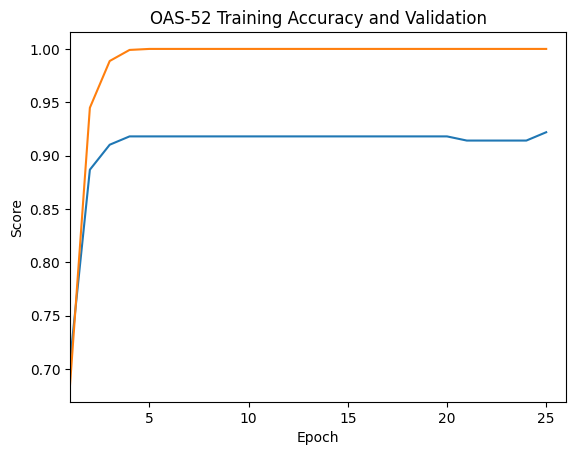

In [5]:
df_h = pd.read_excel(os.getenv("TRAININGTAB"))

plt.plot(df_h["Epoch"],df_h["Validation_accuracy"], label="Validation Accuracy")
plt.plot(df_h["Epoch"],df_h["Training_accuracy"], label="Training Accuracy")

plt.title("OAS-52 Training Accuracy and Validation")
plt.xlim(1,26)

plt.xlabel("Epoch")
plt.ylabel("Score")

savefigtight("training-validation.png")
plt.show()

# Analysis

## Stratification

Graphs of stratifaction within testing/training/validation split sets.

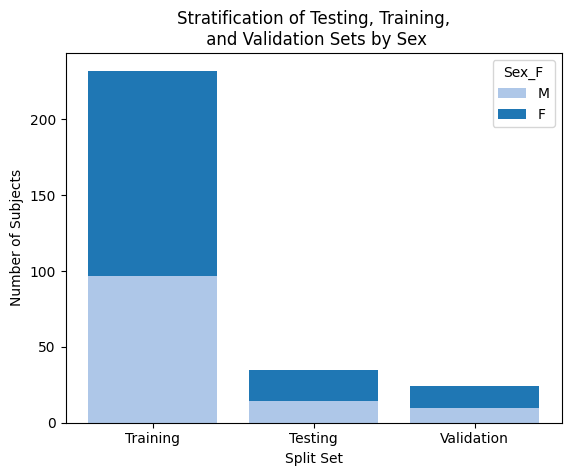

In [6]:
x = np.arange(len(df_split["Split"].unique()))
# print(df_split["Split"].unique())
wid = 0.3
m = 0


plt.bar(x+wid, df_split[df_split["Sex_F"]==0]["Split"].value_counts(), label="M", color=cmap_sex(0))
plt.bar(x+wid, df_split[df_split["Sex_F"]==1]["Split"].value_counts(), bottom=df_split[df_split["Sex_F"]==0]["Split"].value_counts(), label="F", color=cmap_sex(1))

plt.xticks(x+wid, ["Training", "Testing", "Validation"])

plt.legend(title="Sex_F")
plt.title("Stratification of Testing, Training,\n and Validation Sets by Sex")
plt.xlabel("Split Set")
plt.ylabel("Number of Subjects")
savefigtight("sex-strat.png")

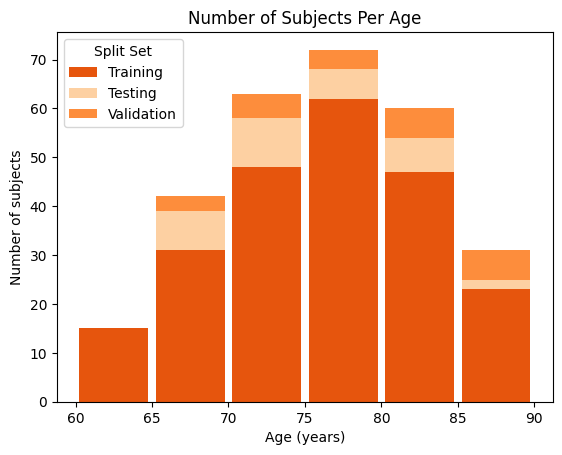

In [7]:
bins =  np.arange(60,95,5)
hist_tr = np.histogram(df_split[df_split["Split"]=="train"]["Age_raw"], bins)
hist_te = np.histogram(df_split[df_split["Split"]=="test"]["Age_raw"],     bins)
hist_va = np.histogram(df_split[df_split["Split"]=="validate"]["Age_raw"], bins)
wid = 0.9


plt.bar(np.arange(0,len(hist_tr[0]), 1), hist_tr[0], label="Training",width=wid, color=cmap_tvt("tr"))
plt.bar(np.arange(0,len(hist_te[0]), 1), hist_te[0], bottom=hist_tr[0], label="Testing", width=wid, color=cmap_tvt("te"))
plt.bar(np.arange(0,len(hist_va[0]), 1), hist_va[0], bottom=hist_tr[0] + hist_te[0], label="Validation", width=wid, color=cmap_tvt("va"))
plt.xticks(np.arange(0,len(hist_tr[0])+1, 1)-0.5, labels=bins)
plt.legend(title="Split Set")
plt.title("Number of Subjects Per Age")
plt.xlabel("Age (years)")
plt.ylabel("Number of subjects")
savefigtight("age-strat.png")
plt.show()


## Evaluation Metrics

In [8]:
# Lambda functions for quickly calculating evaluation metrics

recall = lambda df : float(len(df.query('CM == "TP"')))/(float(len(df.query('CM == "TP"'))+len(df.query('CM == "FN"'))) if float(len(df.query('CM == "TP"'))+len(df.query('CM == "FN"')))!=0 else 1.)
specificity = lambda df : float(len(df.query('TF == 1 & Prediction == 0')))/(float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1'))) if float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1'))) != 0 else 1.)
accuracy = lambda df : float(len(df.query('TF == 1')))/len(df)

tpr = lambda df: recall(df)

fpr = lambda df : float(len(df.query('TF == 0 & Prediction == 1')))/(float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1'))) if float(len(df.query('TF == 1 & Prediction == 0'))+len(df.query('TF == 0 & Prediction == 1')))!=0 else 1.)

In [9]:
import math

def getRec(df):
  """
  Get the recall of the predictions from the provided DataFrame
  Parameters:
    df (pandas.DataFrame): DataFrame of predictions
  Returns:
    out (float) : Recall of predictions
  """
  tp = float(len(df.query('TF == 1 & Prediction == 1')))
  fn = float(len(df.query('TF == 0 & Prediction == 0')))
  if tp+fn == 0:
    return 1
  else:
    return tp/(fn+tp)

def getTPR(df):
  """
  Get the true positive rate (TPR) of the predictions from the provided DataFrame
  Parameters:
    df (pandas.DataFrame): DataFrame of predictions
  Returns:
    out (float) : TPR of predictions
  """

  tp = float(len(df.query('TF == 1 & Prediction == 1')))
  fn = float(len(df.query('TF == 1 & Prediction == 0')))
  if tp+fn == 0:
    return 1
  else:
    return tp/(tp+fn)

def getFPR(df):
  """
  Get the false positive rate (FPR) of the predictions from the provided DataFrame
  Parameters:
    df (pandas.DataFrame): DataFrame of predictions
  Returns:
    out (float) : FPR of predictions
  """
  tn = float(len(df.query('TF == 1 & Prediction == 0')))
  fp = float(len(df.query('TF == 0 & Prediction == 1')))
  if fp+tn == 0:
    return 1
  else:
    return fp/(tn+fp)

def getSpec(df):
  """
  Get the specificity of the predictions from the provided DataFrame
  Parameters:
    df (pandas.DataFrame): DataFrame of predictions
  Returns:
    out (float) : Specificity of predictions
  """
  tn = len(df.query('TF == 1 & Prediction == 0'))
  fp = len(df.query('TF == 0 & Prediction == 1'))
  if (fp+tn) == 0:
    return 1
  else:
    return float(tn)/(fp+tn)

def getAcc(df):
  """
  Get the accuracy of the predictions from the provided DataFrame
  Parameters:
    df (pandas.DataFrame): DataFrame of predictions
  Returns:
    out (float) : Accuracy of predictions
  """
  return float(len(df[df["TF"]==1]))/len(df)

def getMCC(df):
  """
  Get the Matthews correlation coefficient (MCC) of the predictions from the provided DataFrame
  Parameters:
    df (pandas.DataFrame): DataFrame of predictions
  Returns:
    out (float) : MCC of predictions
  """
  tp = float(len(df.query('TF == 1 and Prediction == 1')))
  tn = float(len(df.query('TF == 1 and Prediction == 0')))
  fp = float(len(df.query('TF == 0 and Prediction == 1')))
  fn = float(len(df.query('TF == 0 and Prediction == 0')))

  numer = (tp*tn)-(fp*fn)
  denom = math.sqrt((tp + fp)*(tp + fn)*(tn+fp)*(tn+fn))
  if denom ==0:
    return 1
  else:
    return (numer)/(denom)


def getEOD(df_priv, df_npriv):
  """
  Get the equal opportunity difference (EOD) of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
  Returns:
    out (float) : EOD of predictions
  """
  rec_a = recall(df_priv)
  rec_b = recall(df_npriv)
  return rec_b-rec_a

def getAOD(df_priv, df_npriv):
  """
  Get the average opportunity difference (AOD) of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
  Returns:
    out (float) : AOD of predictions
  """
  tpr_a = tpr(df_priv)
  tpr_b = tpr(df_npriv)


  fpr_a = fpr(df_priv)
  fpr_b = fpr(df_npriv)


  return ((fpr_b-fpr_a)+(tpr_b-tpr_a))/2.

def getDI(df_priv, df_npriv):
  """
  Get the disparate index (DI) of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
  Returns:
    out (float) : DI of predictions
  """
  a = float(len(df_npriv.query("Prediction==1")))/(1. if len(df_npriv)==0 else len(df_npriv))
  b = float(len(df_priv.query("Prediction==1")))/(1. if len(df_priv)==0 else len(df_priv))

  return a/(1. if b==0 else b)

def getSPD(df_priv, df_npriv):
  """
  Get the statistical parity difference (SPD) of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
  Returns:
    out (float) : SPD of predictions
  """
  a = float(len(df_npriv.query("Prediction==1")))/(1. if len(df_npriv)==0 else len(df_npriv))
  b = float(len(df_priv.query("Prediction==1")))/(1. if len(df_priv)==0 else len(df_priv))
  return a-b

def getAccDiff(df_priv, df_npriv, asPercent=False):
  """
  Get the difference of the accuracy of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
    asPercent (bool) : If true, returns the result as a percentage instead of a portion
  Returns:
    out (float) : Difference in accuracy
  """
  a = accuracy(df_npriv)
  b = accuracy(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getRecDiff(df_priv, df_npriv, asPercent=False):
  """
  Get the difference of the accuracy of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
    asPercent (bool) : If true, returns the result as a percentage instead of a portion
  Returns:
    out (float) : Difference in recall
  """
  a = recall(df_npriv)
  b = recall(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getSpecDiff(df_priv, df_npriv, asPercent=False):
  """
  Get the difference of the specificity of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
    asPercent (bool) : If true, returns the result as a percentage instead of a portion
  Returns:
    out (float) : Difference in specificity
  """
  a = specificity(df_npriv)
  b = specificity(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b

def getMCCDiff(df_priv, df_npriv, asPercent=False):
  """
  Get the difference of the Matthews correlation coefficient (MCC) of the predictions from the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
    asPercent (bool) : If true, returns the result as a percentage instead of a portion
  Returns:
    out (float) : Difference in MCC
  """
  a=getMCC(df_npriv)
  b=getMCC(df_priv)
  if asPercent:
    return 100.*(a-b)/b
  else:
    return a-b


def getFairness(df_priv, df_npriv):
  """
  Get the a DataFrame containing all all the fairness metric scores for the provided DataFrames
  Parameters:
    df_priv (pandas.DataFrame): DataFrame of predictions from the privledged group
    df_npriv (pandas.DataFrame): DataFrame of predictions from the non-privledged group
  Returns:
    out (pandas.DataFrame) : DataFrame containing all fairness metric scores
  """
  return pd.DataFrame({"DI": [getDI(df_priv, df_npriv)], "EOD":[getEOD(df_priv, df_npriv)], "AOD":[getAOD(df_priv, df_npriv)], "SPD":[getSPD(df_priv, df_npriv)]})


Overall performance metrics for the OAS-52 model.

In [10]:
print(f'Accuracy:       {accuracy(df_pred):5.3f}')
print(f'Recall:         {recall(df_pred):5.3f}')
print(f'Specificity:    {specificity(df_pred):5.3f}')
print(f'MCC:            {getMCC(df_pred):+5.3f}')


Accuracy:       0.839
Recall:         0.808
Specificity:    0.863
MCC:            +0.672


In [11]:
def getMetrics(df, title=""):
  if len(df) < 1:
    return pd.DataFrame({"ACC":[0.], "SPE":[0.], "REC":[0.], "MCC":[0.0]})
  acc =  [getAcc(df)]
  spec = [getSpec(df)]
  rec = [getRec(df)]
  mcc = [getMCC(df)]
  return pd.DataFrame({"ACC":acc, "SPE":spec, "REC":rec, "MCC":mcc})

def getSexMetrics(df):
  df_f = getMetrics(df[df["Sex_F"]==1])
  df_m = getMetrics(df[df["Sex_F"]==0])
  df_f["Sex_F"] = [1]
  df_m["Sex_F"] = [0]
  return pd.merge(df_f, df_m, how="outer")

def getAgeRange(df, min, max):
  df_t = df[df["Age_raw"]>=min]
  df_t = df_t[df_t["Age_raw"]<max]
  df_t["Age_range"] = f'{min:d} to {max-1:d}'
  return df_t, f'{min:d} to {max-1:d}'

def getAgeMetrics(df):

  df_age = pd.DataFrame(columns=["Age","ACC","SPE","REC","MCC"])

  bins = np.arange(65, 100, 5)


  for i in bins[:-1]:
    df_t, age_range = getAgeRange(df, i, i+5)
    df_m = getMetrics(df_t)
    df_m["Age"] = age_range
    df_age = pd.merge(df_age, df_m, how="outer")

  return df_age

def getAgeSexMetrics(df):
  df_age = pd.DataFrame(columns=["Age_range","M/F","ACC","SPE","REC","MCC"])

  bins = np.arange(65, 100, 5)

  df_f = df[df["M/F"]=="F"]
  df_m = df[df["M/F"]=="M"]


  for i in bins[:-1]:
    df_tf, age_range = getAgeRange(df_f, i, i+5)
    df_tm, age_range = getAgeRange(df_m, i, i+5)

    df_metf = getMetrics(df_tf)
    df_metm = getMetrics(df_tm)

    df_metm["M/F"] = ["M"]
    df_metf["M/F"] = ["F"]
    df_metm["Age_range"] = age_range
    df_metf["Age_range"] = age_range
    df_met = pd.merge(df_metf, df_metm, how="outer")


    df_age = pd.merge(df_age, df_met, how="outer")
  return df_age


In [12]:
df_sex = getSexMetrics(df_pred)
df_age = getAgeMetrics(df_pred)
df_age_sex = getAgeSexMetrics(df_pred)


df_scan_sex = getSexMetrics(df_scan_pred)
df_scan_age = getAgeMetrics(df_scan_pred)
df_scan_age_sex = getAgeSexMetrics(df_scan_pred)

df_subj_sex = getSexMetrics(df_subj_pred)
df_subj_age = getAgeMetrics(df_subj_pred)
df_subj_age_sex = getAgeSexMetrics(df_subj_pred)

In [13]:
def addIdealRect(ax):
  ideal = mpl.patches.Rectangle((-10, -0.1), 40, 0.2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.1)
  ax.add_patch(ideal)


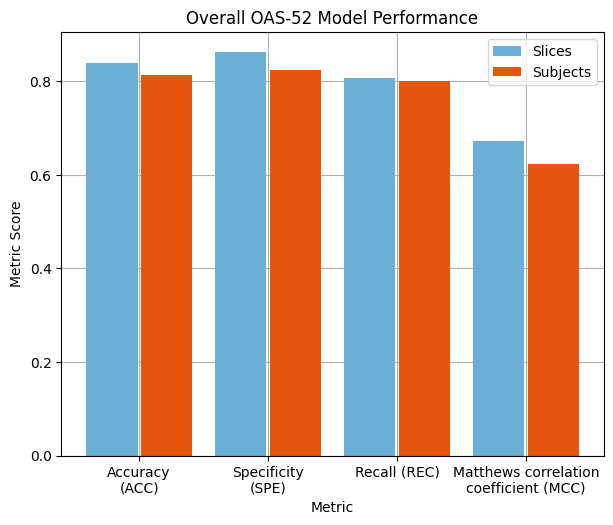

In [14]:
df_overall_scan = getMetrics(df_scan_pred)
df_overall_slices = getMetrics(df_pred)

width=0.8
padding = 0.05
i = 0
ticks = np.arange(0,len(df_overall_scan.keys())*2, 2)
plt.figure(figsize=(7,5.5))
ax = plt.subplot()
plt.xlabel("Metric")
plt.ylabel("Metric Score")
ax.set_title("Overall OAS-52 Model Performance")

ax.bar(ticks, df_overall_slices.iloc[0], width=width, color=cmap_tab(0.05), label="Slices")
ax.bar(ticks+(padding+width), df_overall_scan.iloc[0],  width=width, color=cmap_tab(0.2), label="Subjects")
ax.grid(visible=True)
ax.set_xticks(ticks+(padding+width)/2, labels=[abbr_n[k] for k in  df_overall_scan.keys()])
ax.set_axisbelow(True)
plt.legend()

savefigtight("overall-performance-subjects.png")


In [15]:
def graphPredictBySex(df_sex, title="sex-metrics.png"):
  x_ticks = np.linspace(0,5,len(df_sex.keys())-1)
  wid = 0.5
  padding = 0.05
  i = 0

  fig, ax = plt.subplots()

  for s in df_sex["Sex_F"].unique():
    row = df_sex[df_sex["Sex_F"]==s].values[0][:-1]
    oset = (wid+padding)*i
    ax.bar(x=x_ticks+oset, height=row, width=wid, label=("F" if s==1 else "M"), color=cmap_sex(s))
    i+=1
    ax.set_xticks(x_ticks+(wid+padding)/2, labels=df_sex[df_sex["Sex_F"]==s].keys()[:-1])
    ax.set_yticks(np.arange(-0.2,1.1,0.1))
  ax.legend(title="Sex")
  ax.set_xlabel("Metric")
  ax.set_xlabel("Value")
  ax.set_title("Prediction Metrics by Sex")
  ax.grid(visible=True, axis='y',zorder=-1)
  ax.set_axisbelow(True)
  savefigtight(title)
  plt.show()
  row_f = df_sex[df_sex["Sex_F"]==1].values[0][:-1]
  row_m = df_sex[df_sex["Sex_F"]==0].values[0][:-1]
  print(df_sex)
  print(row_m-row_f)


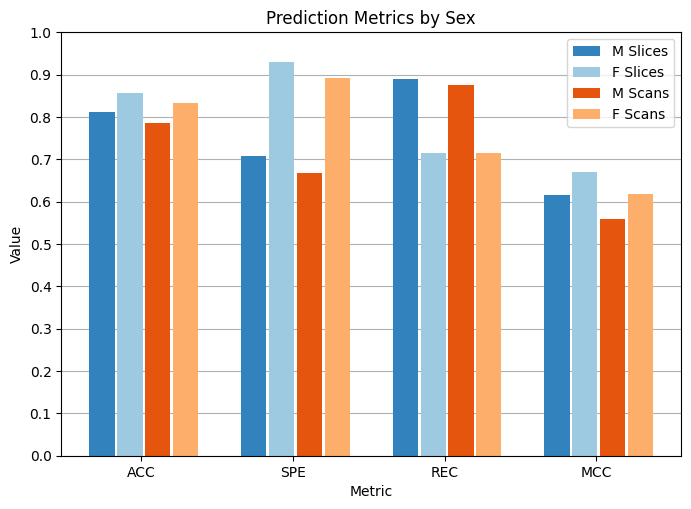

In [16]:
def graphPredictBySexBoth(df_sex, df_scan_sex, title="sex-metrics.png"):
  x_ticks = np.array([0.,3.,6.,9.])
  wid = 0.5
  padding = 0.05
  i = 0
  fig, ax = plt.subplots(figsize=(8,5.5))

  for s in df_sex["Sex_F"].unique():
    row = df_sex[df_sex["Sex_F"]==s].values[0][:-1]
    oset = (wid+padding)*i
    ax.bar(x=x_ticks+oset, height=row, width=wid, label=("F Slices" if s==1 else "M Slices"), color=cmap_tab(s/10.))
    i+=1
    ax.set_xticks(x_ticks+(wid+padding)/2, labels=df_sex[df_sex["Sex_F"]==s].keys()[:-1])
    ax.set_yticks(np.arange(-0.2,1.1,0.1))

  i = 0
  for s in df_scan_sex["Sex_F"].unique():
    row = df_scan_sex[df_scan_sex["Sex_F"]==s].values[0][:-1]
    oset = (wid+padding)*i+1+padding*2
    ax.bar(x=x_ticks+oset, height=row, width=wid, label=("F Scans" if s==1 else "M Scans"), color=cmap_tab((s+2)/10.))
    i+=1
    ax.set_xticks(x_ticks+(wid+padding+1)/2, labels=df_scan_sex[df_scan_sex["Sex_F"]==s].keys()[:-1])
    ax.set_yticks(np.arange(0,1.1,0.1))
  ax.legend()
  ax.set_xlabel("Metric")
  ax.set_ylabel("Value")
  ax.set_title("Prediction Metrics by Sex")
  ax.grid(visible=True, axis='y',zorder=-1)
  ax.set_axisbelow(True)
  savefigtight(title)
  plt.show()
  ax.set_ylim(0, 1.2)





graphPredictBySexBoth(df_sex, df_scan_sex, "sex-metrics-scans.png")

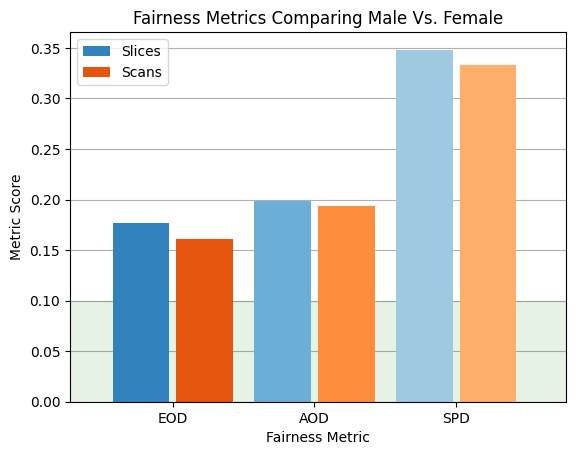

In [17]:
x_ticks = np.arange(0, 3, 1)
width = 0.4
padding = 0.05

eq_sex = getFairness(df_pred[df_pred["Sex_F"]==1], df_pred[df_pred["Sex_F"]==0])
eq_subj_sex = getFairness(df_scan_pred[df_scan_pred["Sex_F"]==1], df_scan_pred[df_scan_pred["Sex_F"]==0])

fig, ax = plt.subplots()
ideal = mpl.patches.Rectangle((-1.5, 0), 6, 0.1, linewidth=1, edgecolor='g', facecolor='g', alpha=0.1)
ax.add_patch(ideal)
ax.grid(visible=True, axis='y')
ax.bar(x_ticks, eq_sex.iloc[0][1:], color=[cmap_tab(0.00), cmap_tab(0.05), cmap_tab(0.10)], width=width, label="Slices")

ax.bar(x_ticks+(width+padding), eq_subj_sex.iloc[0][1:], color=[cmap_tab(0.2), cmap_tab(0.25), cmap_tab(0.3)], width=width, label="Scans")
ax.set_xticks(x_ticks+(width+padding)/2, labels=["EOD", "AOD", "SPD"])
ax.set_title("Fairness Metrics Comparing Male Vs. Female")
ax.set_xlabel("Fairness Metric")
ax.set_ylabel("Metric Score")
ax.set_axisbelow(True)
ax.set_xlim(-0.5, 3)
plt.legend()


savefigtight("fairness-sex-scans.png")
plt.show()

In [18]:
def fairnessByAge(df):
  df_met = pd.DataFrame(columns=["Age_range", "Weight", "DI","EOD", "AOD", "SPD"])

  bins = np.arange(65, 100, 5)
  for i in bins[:-1]:
    df_age, age_range = getAgeRange(df, i, i+5)
    df_nAge = df.drop(df[df["MRI ID"].isin(df_age["MRI ID"])].index)
    weight = float(len(df_age))/len(df_nAge)
    df_a = getFairness(df_age, df_nAge)
    df_a["Weight"] = weight
    df_a["Age_range"] = age_range
    df_met =pd.merge(df_met, df_a, how='outer')

  return df_met

def fairnessByUnique(df, key):
  df_met = pd.DataFrame(columns=[key, "Weight", "DI","EOD", "AOD", "SPD"])
  for val in df[key].unique():
    df_in = df[df[key] == val]
    df_out = df[df[key]!=val]
    weight = float(len(df_in))/len(df_out)
    df_fair = getFairness(df_out, df_in)
    df_fair[key] = val
    df_fair["Weight"] = weight

    df_met =pd.merge(df_met, df_fair, how='outer')
  return df_met.sort_values(by=key)

def fairnessByRange(df, key, numBins):

  df_met = pd.DataFrame(columns=[key, "Weight", "DI","EOD", "AOD", "SPD"])
  bins = np.linspace(df[key].min(), df[key].max(), numBins)
  for i in range(len(bins)-1):
    low = bins[i]
    high = bins[i+1]

    df_in = df.query(key + " <= @high & " + key + " > @low")
    df_out = df.drop(df[df[key].isin(df_in[key])].index)

    weight = float(len(df_in))/len(df_out)
    df_fair = getFairness(df_out, df_in)
    df_fair[key] = (low+high)/2.
    df_fair["Weight"] = weight

    df_met =pd.merge(df_met, df_fair, how='outer')
  return df_met.sort_values(by=key)


df_age_fairness = fairnessByAge(df_pred)
df_scan_age_fairness = fairnessByAge(df_scan_pred)
df_subj_age_fairness = fairnessByAge(df_subj_pred)


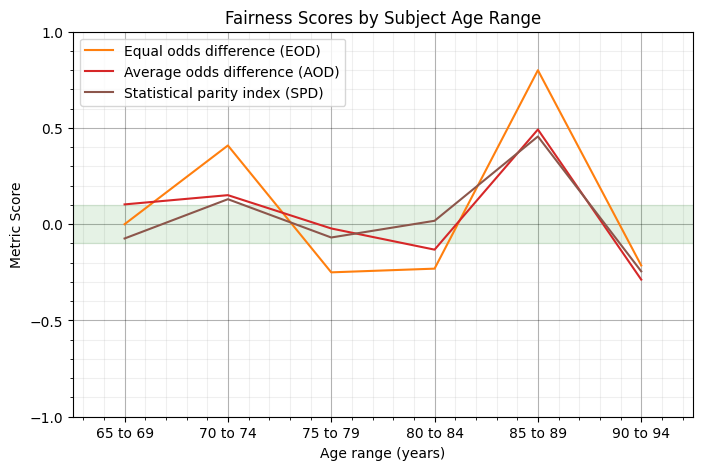

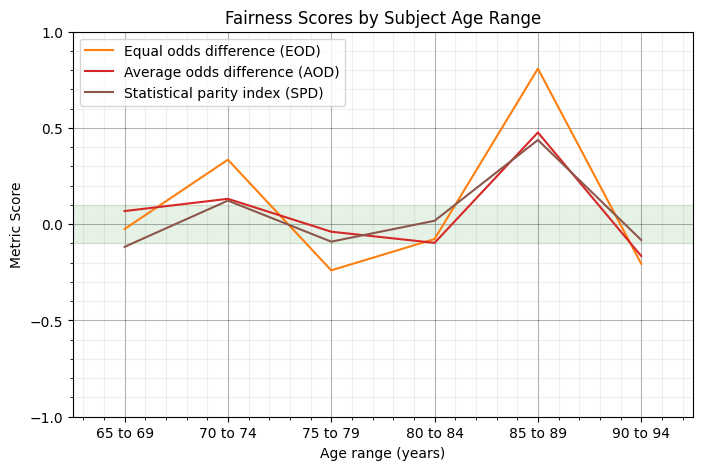

In [32]:
def graphFairnessByAge(df_age_fairness, title="fairness-age.png"):
  fig, ax = plt.subplots(figsize=(8,5))

  wid = 0.2
  padding=0.05

  t = len(df_pred)
  i = 0.1
  m = 0

  ticks = np.arange(0, len(df_age_fairness["Age_range"].unique()), 1)

  for k in df_age_fairness.keys()[3:]:
    ax.plot(ticks, df_age_fairness[k], label=abbr[k], color=cmap_tab2(i))
    i+=0.2
    m+=1

  ax.set_xticks(ticks=ticks, labels=df_age_fairness["Age_range"].unique())

  ax.set_yticks([-1.,-0.5 ,0., 0.5, 1.])
  ax.set_yticks(np.arange(-1., 1.2, 0.2), minor=True)


  ax.grid(which="minor", visible=True, alpha=0.2)
  ax.grid(which="major", color='black', alpha=0.3, axis='both')
  ax.minorticks_on()


  ax.set_xlim(-0.5, ticks.max()+0.5)
  ax.set_axisbelow(True)
  ax.set_xlabel("Age range (years)")
  ax.set_ylabel("Metric Score")
  ax.set_title("Fairness Scores by Subject Age Range")

  rect = mpl.patches.Rectangle((-1, -0.1), 40, 0.2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.1)
  ax.add_patch(rect)

  plt.legend()
  savefigtight(title)
  plt.show()

graphFairnessByAge(df_scan_age_fairness, "fairness-age-subjects.png")


graphFairnessByAge(df_age_fairness)


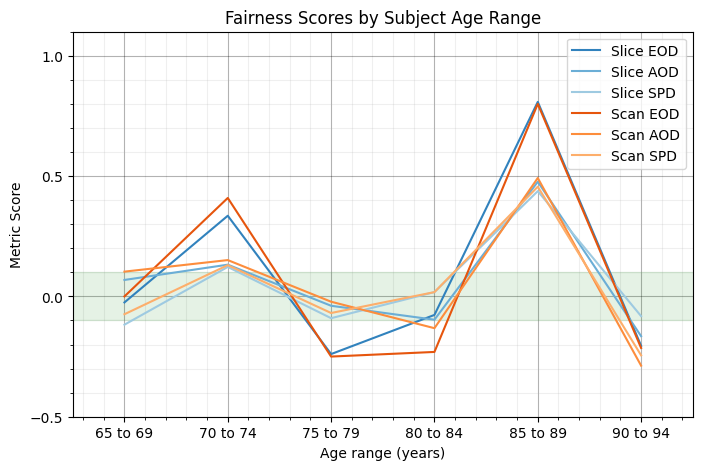

In [20]:
def graphFairnessByAgeSubject(df_age_fairness, df_subj_age_fairness, title="fairness-age-subject.png"):
  fig, ax = plt.subplots(figsize=(8,5))

  wid = 0.2
  padding=0.05

  t = len(df_pred)
  i = 0.0
  m = 0

  ticks = np.arange(0, len(df_age_fairness["Age_range"].unique()), 1)

  for k in df_age_fairness.keys()[3:]:
    ax.plot(ticks, df_age_fairness[k], label="Slice " +  k, color=cmap_tab(i))
    i+=0.05
    m+=1

  i = 0.2
  for k in df_subj_age_fairness.keys()[3:]:
    ax.plot(ticks, df_subj_age_fairness[k], label="Scan " +  k, color=cmap_tab(i))
    i+=0.05
    m+=1

  ax.set_xticks(ticks=ticks, labels=df_age_fairness["Age_range"].unique())

  ax.set_yticks([-0.5 ,0., 0.5, 1.])
  ax.set_yticks(np.arange(-0.5, 1.2, 0.2), minor=True)


  ax.grid(which="minor", visible=True, alpha=0.2)
  ax.grid(which="major", color='black', alpha=0.3, axis='both')
  ax.minorticks_on()


  ax.set_xlim(-0.5, ticks.max()+0.5)
  ax.set_axisbelow(True)
  ax.set_xlabel("Age range (years)")
  ax.set_ylabel("Metric Score")
  ax.set_title("Fairness Scores by Subject Age Range")

  rect = mpl.patches.Rectangle((-1, -0.1), 40, 0.2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.1)
  ax.add_patch(rect)

  plt.legend()
  savefigtight(title)
  plt.show()

graphFairnessByAgeSubject(df_age_fairness, df_scan_age_fairness, "fairness-age-scan.png")

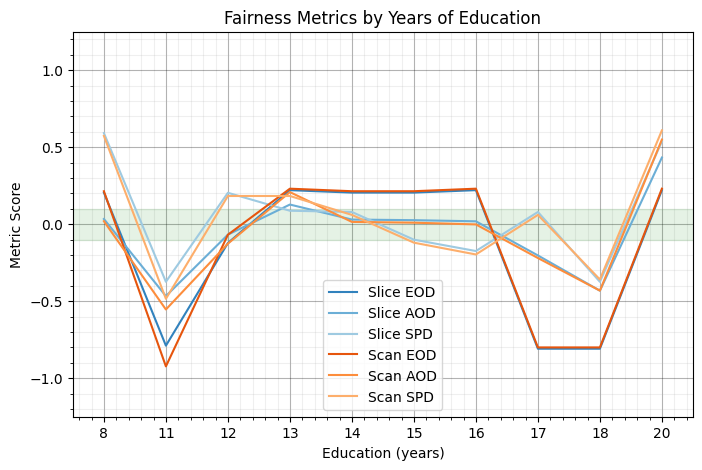

In [33]:
def graphFairnessByUniqueScan(df_pred, df_scan_pred, key, xlabel, title, filename):
  fig, ax = plt.subplots(figsize=(8,5))
  df_unique = fairnessByUnique(df_pred, key).sort_values(by=key)
  df_scan_unique = fairnessByUnique(df_scan_pred, key).sort_values(by=key)

  wid = 0.2
  padding=0.05

  t = len(df_pred)
  i = 0.0
  m = 0

  ticks = np.arange(0, len(df_unique[key].unique()), 1)

  for k in df_unique.keys()[3:]:
    ax.plot(ticks, df_unique[k], label="Slice " + k, color=cmap_tab(i))
    i+=0.05
    m+=1

  i = 0.2
  for k in df_scan_unique.keys()[3:]:
    ax.plot(ticks, df_scan_unique[k], label="Scan "+k, color=cmap_tab(i))
    i+=0.05
    m+=1

  ax.set_xticks(ticks=ticks, labels=df_unique[key].unique())

  ax.set_yticks([-1.,-0.5 ,0., 0.5, 1.])
  ax.set_ylim(-1.25, 1.25)
  ax.set_yticks(np.arange(-1., 1.2, 0.2), minor=True)


  ax.grid(which="minor", visible=True, alpha=0.2)
  ax.grid(which="major", color='black', alpha=0.3, axis='both')
  ax.minorticks_on()


  ax.set_xlim(-0.5, ticks.max()+0.5)
  ax.set_axisbelow(True)
  ax.set_xlabel(xlabel)
  ax.set_ylabel("Metric Score")
  ax.set_title(title)

  addIdealRect(ax)

  plt.legend()
  savefigtight(filename)
  plt.show()

graphFairnessByUniqueScan(df_pred, df_scan_pred,"EDUC_raw","Education (years)", "Fairness Metrics by Years of Education", "fairness-educ.png")

# Images

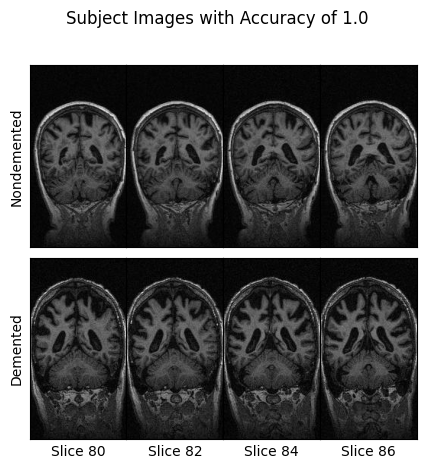

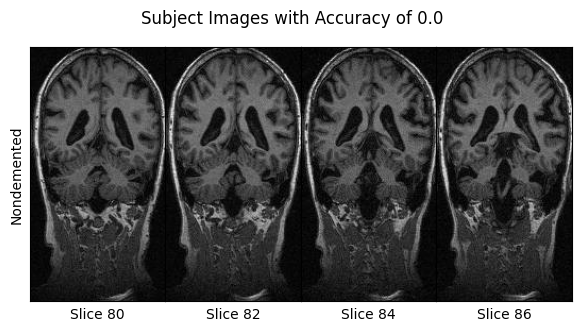

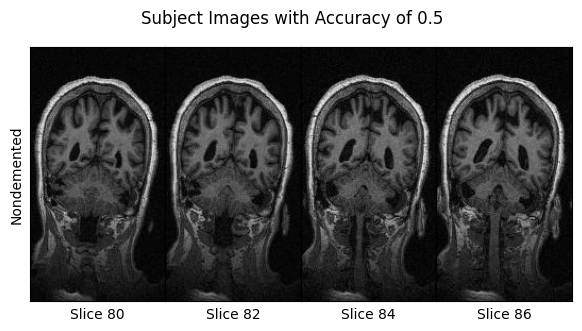

In [26]:
def plotTestingImage(basenames, title, filename):
  slices = [80, 82, 84, 86]
  rows = len(basenames)
  gspec = mpl.gridspec.GridSpec(rows, 4)
  gspec.update(wspace=0, hspace=0)
  # fig, ax = plt.subplots(rows, 4, sharex='all', sharey='all', tight_layout="tight")

  for r in range(rows):
    for i, slice in enumerate(slices):
      ax = plt.subplot(gspec[r*4+i])
      fname = f'{os.path.join(os.getenv("JPG"), "test", basenames[r])}_{slice}.jpg'
      image = plt.imread(fname)
      tr = mpl.transforms.Affine2D().translate(-128, -240).rotate_deg(180)
      ax.imshow(image, transform=tr+ax.transData)
      # ax.get_xaxis().set_visible(False)
      # ax.get_yaxis().set_visible(False)

      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_aspect('equal')
      if r == rows-1:
        ax.set_xlabel(f"Slice {slice}")
      if i == 0:
        if r==0:
          ax.set_ylabel("Nondemented")
        if r==1:
          ax.set_ylabel("Demented")
  plt.suptitle(title)
  savefigtight(filename)
  plt.show()
plt.figure(figsize=(5,5))


plotTestingImage(["class_0/OAS2_0008_MR1_F2","class_1/OAS2_0016_MR2_F1"], "Subject Images with Accuracy of 1.0", "acc-100-slices.png")

plt.figure(figsize=(7,3.4))
plotTestingImage(["class_0/OAS2_0070_MR2_F1"], "Subject Images with Accuracy of 0.0", "acc-0-slices.png")
plt.figure(figsize=(7,3.4))

plotTestingImage(["class_0/OAS2_0096_MR2_F1"], "Subject Images with Accuracy of 0.5", "acc-50-slices.png")


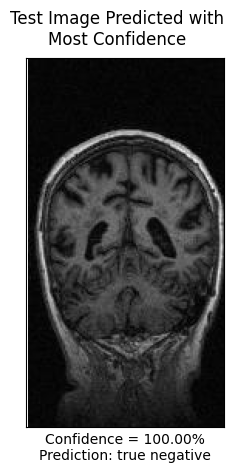

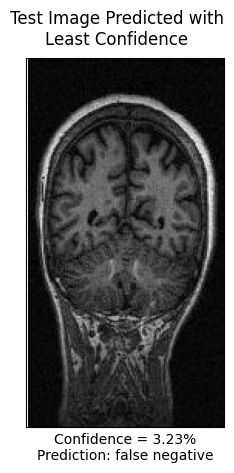

In [27]:
def makeSingleTestImage(imagefile, title, filename, xlabel=""):
  image = plt.imread(os.path.join(os.getenv("JPG"), "test", imagefile))
  gspec = mpl.gridspec.GridSpec(1, 1)
  gspec.update(wspace=0, hspace=0)

  ax = plt.subplot(gspec[0])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect('auto')

  tr = mpl.transforms.Affine2D().translate(-128, -240).rotate_deg(180)
  ax.imshow(image, transform=tr+ax.transData)
  ax.set_xlabel(xlabel)
  plt.suptitle(title)

  savefigtight(filename)
  plt.show()



conf_max = df_pred[df_pred["Confidence"] == df_pred["Confidence"].max()].iloc[0]
conf_min = df_pred[df_pred["Confidence"] == df_pred["Confidence"].min()].iloc[0]

makeSingleTestImage(os.path.join("class_0" if conf_max["Group_norm"]==0 else "class_1", conf_max["File"]), 'Test Image Predicted with\nMost Confidence', "most-confidence.png", f'Confidence = {conf_max["Confidence"]*100:.2f}%\nPrediction: {str(conf_max["CM_full"])}')
makeSingleTestImage(os.path.join("class_0" if conf_min["Group_norm"]==0 else "class_1", conf_min["File"]), 'Test Image Predicted with\nLeast Confidence', "least-confidence.png", f'Confidence = {conf_min["Confidence"]*100:.2f}%\nPrediction: {str(conf_min["CM_full"])}')
